In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

# Objective:
### To use indexed Medical Subject Headings (MeSH) in MEDLINE citations and explore associations between four Marfan-like Syndromes and the proteins indexed in the citations by using Naive Bayes, k Nearest Neigbors and other models.

In [9]:
# Methods:
### The four syndrome terms, Marfan Syndrome (MfS), Ehlers-Danlos Syndrome (EDS), Loeys-Dietz Syndrome (LDS) and Weill-Marchesani Syndrome(WMS) were used to search PubMed/MEDLINE. Indexed protein and enzyme MeSH terms for each citation were selected by matching to downloaded MeSH descriptors. The subheadings and stars designating major topic were removed and underscores used to replace spaces. This data was transformed using a Sklearn CountVectorizer to produce a sparse matrix dataframe with each of the most frequent 33 terms as columns. Protein terms were studied to find associations with a specific syndrome term. The strongest associtation was found to be between MfS and microfilament proteins and fibrillins, and to a lesser extent fibrillin-1, collagen and Transforming Growth Factor beta. These association was studied using various models and repeated with filtered data to improve modeling.

In [17]:
# Selection of relevant MeSH Terms: to obtain list with Protein (& Enzyme Terms) from MeSH ASCII file and 4 Syndrome search terms 
relevant_terms = ['Marfan Syndrome', 'Loeys-Dietz Syndrome', 'Ehlers-Danlos Syndrome', 'Weill-Marchesani Syndrome']

# Downloaded MeSH ASCII formathttps://www.nlm.nih.gov/databases/download/mesh.html
fp = open('./MH Descriptor 2019.txt') 
line = " "
err_count = 0
val_count = 0
line_count = 0
while line != '':                  # While loop to extract only the terms that have MN = 
    try:
        while "MH" not in line:
            line = fp.readline()
            line_count += 1       
        
        MH = line[5:-1]
        while "MN" not in line:
            line = fp.readline()
            line_count += 1

        has_correct_MN = False
        while "MN" in line:
            if "D08.811" in line or "D12.776" in line:
                has_correct_MN = True
            line = fp.readline()
            line_count += 1

        if has_correct_MN:
            val_count += 1
            relevant_terms.append(MH)

        while "*NEWRECORD" not in line and line != '':
            line = fp.readline()
            line_count += 1
    except:
        err_count += 1
        line = " "
        while "*NEWRECORD" not in line and line != '':
            line = fp.readline()
            line_count += 1
print('Complete', val_count, err_count) # Extracted 4548 Protein and Enzyme Terms and added to relevant_terms
fp.close()

Complete 4548 4


In [18]:
marf_df = pd.read_csv('./data_pubmed_marfanlike1.csv') # Read in PubMed Search Results obtained using BioPython
marf_df.head(5) # Data needs cleaning,  mesh_terms column has the data

,Unnamed: 0,pmid,journal,pt,title,abstract,mesh_terms
0,0,27273746,American journal of medical genetics. Part A,['Journal Article'],"Quality of life, unmet needs, and iatrogenic i...","Ehlers-Danlos Syndrome, hypermobility type (ED...","['Adult', 'Ehlers-Danlos Syndrome/*epidemiolog..."
1,1,4835252,Circulation,['Journal Article'],The variable spectrum of echocardiographic man...,NaN,"['Adolescent', 'Adult', 'Chordae Tendineae/inj..."
2,2,23582510,Journal of the American Society of Echocardiog...,"['Journal Article', 'Multicenter Study', 'Rese...","Echocardiographic methods, quality review, and...",BACKGROUND: The Pediatric Heart Network is con...,"['Adolescent', 'Adrenergic beta-1 Receptor Ant..."
3,3,10498154,The American journal of cardiology,"['Journal Article', ""Research Support, Non-U.S...",Clinical outcome in the Marfan syndrome with a...,This study reviewed the utility of echocardiog...,"['Adolescent', 'Adult', 'Aorta/diagnostic imag..."
4,4,5969525,"Neurologia, neurochirurgia i psychiatria polska","['Case Reports', 'Journal Article']",[Problems of psychiatric symptomatology in the...,NaN,"['Adolescent', 'Anxiety/*complications', 'Huma..."


In [19]:
marf_df = marf_df.drop(columns=['Unnamed: 0', 'pmid', 'journal', 'pt', 'title', 'abstract']) 
# Drop first column and all other columns, keep only MeSH column and index
marf_df.mesh_terms[0], marf_df.shape # Check a row to see all the MeSH terms, check shape, all 8848 rows present

("['Adult', 'Ehlers-Danlos Syndrome/*epidemiology/*rehabilitation/therapy', 'Female', 'Focus Groups', '*Health Services Needs and Demand', 'Humans', 'Iatrogenic Disease', 'Male', 'Middle Aged', 'Physical Therapy Modalities', 'Quality of Health Care', '*Quality of Life', 'Risk Factors', 'Surveys and Questionnaires', 'Young Adult']",
 (8848, 1))

In [20]:
# marf_df.mesh_terms contains the information we need to analyze
# Code for cleaning and extracting each relevant MeSH terms for each row e.g. row [0] only the Syndrome term: Ehlers-Danlos Syndrome is relevant, no protein terms present

marf_df['mesh_terms'] = marf_df.mesh_terms.str.strip('[]') # Remove square brackets from MeSH terms
marf_df['mesh_terms'] = marf_df.mesh_terms.str.replace('*', '') # Remove star to designate major MeSH terms
rel_terms = set(relevant_terms) # Convert relevant_terms to set for ease of finding intersection

final_terms = [] # Intitialize list of terms for analysis this will be a list of 8848 lists
final_simple_list = [] # Intitialize list of terms for analysis this will be a simple list of 8848 rows with relevant term(s) in each row 

for temp_mt in marf_df['mesh_terms']:  # To extract each MeSH term from each row
    t = temp_mt.split('"') # To remove terms with double quotes (e.g. "Nurse's Role")
    if  len(t) > 2:
        temp_mt = t[0]+t[2][2:]
    elif len(t) == 2 and temp_mt[0] != '"':
        temp_mt = t[0]
    elif len(t) == 2:
        temp_mt = t[1][2:]
    
    end_mt= -1  # Initializing for start of search 
    mt_set = set() # Initializing an empty set to capture all the MeSH terms in each row, this set will be used to keep only the terms in the relevant_list (or rel_list)
    
    while (temp_mt.find("'", end_mt+1) != -1):   # Loop through until all terms have been found  

        start_mt = temp_mt.find("'", end_mt+1) # Find beginning and end quotes to extract MeSH term
        end_mt = temp_mt.find("'", start_mt+1)
    
        slash_pos = temp_mt[start_mt+1 : end_mt].find("/") # To delete subheadings when present
        if slash_pos != -1:
            truncated_mt= temp_mt[start_mt+1 : start_mt+slash_pos+1]
        else:
            truncated_mt= temp_mt[start_mt+1 : end_mt]     
        
        mt_set.add(truncated_mt) # mt_set contains all MeSH terms for the row
        
    intersect = mt_set & rel_terms # Keeps only the MeSH terms from row that are relevant_terms 
    if len(intersect) > 0:
        final_terms.append([term.replace(' ','_') for term in intersect])
        final_simple_list.append(' '.join(final_terms[-1])) # Space separated
    else:
        final_terms.append([])
        final_simple_list.append([])
    # For every term which is in both relevant terms and mt_set, replace spaces with underscores so that CountVectorizer does not split the term up into words
    # add to final_terms list

final_terms[0:10] # List of lists for each PMID
final_simple_list[:10] # Single list of MeSH terms in each row

['Ehlers-Danlos_Syndrome',
 'Marfan_Syndrome',
 'Marfan_Syndrome',
 'Marfan_Syndrome',
 'Marfan_Syndrome',
 'Marfan_Syndrome',
 'Nerve_Tissue_Proteins Ehlers-Danlos_Syndrome',
 'Ehlers-Danlos_Syndrome',
 'Ehlers-Danlos_Syndrome',
 'Marfan_Syndrome']

In [21]:
# Use CountVectorizer to select terms with frequency of at least 20 after trying different numbers
def csv_analyzer(s):
    "split on space" 
    return [term for term in s.split()]
vect = CountVectorizer(analyzer=csv_analyzer, min_df=20) # tried different minimum doc freq, min_df=1: 489 terms, min_df=2 233 terms, min_df= 10: 64, selected min_df=20: 33 terms
X = final_simple_list
fsldn = vect.fit_transform(X)

In [22]:
top_terms = vect.get_feature_names()
top_terms [:5], len(vect.get_feature_names()) # List of the 489 most common protein terms & 4 search terms. Since already know the strongest associations, all proteins included, not top 33

(['ADAMTS_Proteins',
  'ADAM_Proteins',
  'Cation_Transport_Proteins',
  'Collagen',
  'Collagen_Type_I'],
 33)

In [23]:
# Generate Term frequency Dataframe, this Dataframe will be used for further analysis and modeling
vect = CountVectorizer(analyzer=csv_analyzer, min_df=20, lowercase=False) 
tf = pd.DataFrame(vect.fit_transform(final_simple_list).toarray(), columns=vect.get_feature_names())
tf.shape 
tf.head(5)

,ADAMTS_Proteins,ADAM_Proteins,Cation_Transport_Proteins,Collagen,Collagen_Type_I,Collagen_Type_III,Collagen_Type_V,Ehlers-Danlos_Syndrome,Elastin,Epidermal_Growth_Factor,...,Protein-Serine-Threonine_Kinases,Proteoglycans,"Receptor,_Transforming_Growth_Factor-beta_Type_I","Receptor,_Transforming_Growth_Factor-beta_Type_II","Receptors,_Transforming_Growth_Factor_beta",Recombinant_Proteins,Tenascin,Transforming_Growth_Factor_beta,Transforming_Growth_Factor_beta1,Weill-Marchesani_Syndrome
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Generate Document Frequency of each ofthe 33 terms
vect = CountVectorizer(analyzer=csv_analyzer, min_df=20, lowercase=False)
df = vect.fit_transform(final_simple_list).toarray().sum(axis=0)
pd.DataFrame(df.reshape(1, 33), columns=vect.get_feature_names())

,ADAMTS_Proteins,ADAM_Proteins,Cation_Transport_Proteins,Collagen,Collagen_Type_I,Collagen_Type_III,Collagen_Type_V,Ehlers-Danlos_Syndrome,Elastin,Epidermal_Growth_Factor,...,Protein-Serine-Threonine_Kinases,Proteoglycans,"Receptor,_Transforming_Growth_Factor-beta_Type_I","Receptor,_Transforming_Growth_Factor-beta_Type_II","Receptors,_Transforming_Growth_Factor_beta",Recombinant_Proteins,Tenascin,Transforming_Growth_Factor_beta,Transforming_Growth_Factor_beta1,Weill-Marchesani_Syndrome
0,24,24,26,560,37,116,47,3064,75,39,...,106,31,57,94,125,30,48,157,26,37


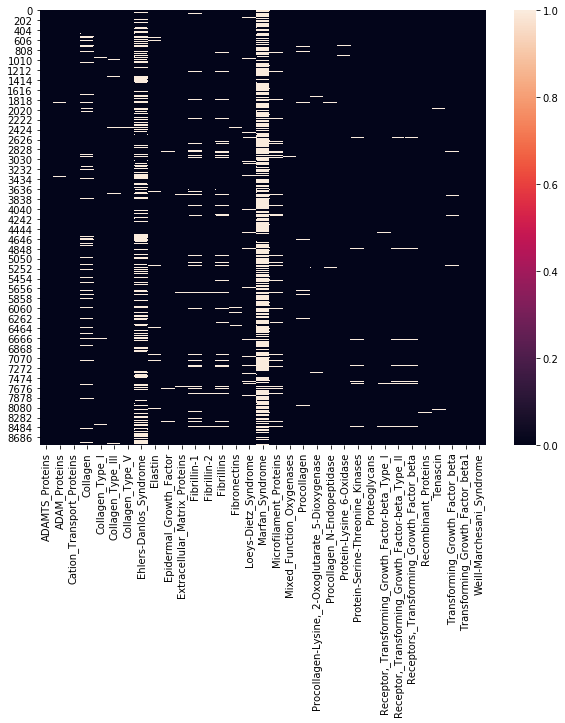

In [25]:
# Plot heatmap, this plots map of each 33 terms in each row of the Dataframe. Looks interesting, but not very informative since need 4 Syndrome terms versus protein terms 
plt.figure(figsize=(10,8))
sns.heatmap(tf);

In [26]:
# To get a table of Syndrome Terms versus Protein terms
disease_df = ['Marfan_Syndrome', 'Loeys-Dietz_Syndrome', 'Ehlers-Danlos_Syndrome', 'Weill-Marchesani_Syndrome']
tabulated_results=tf.groupby(disease_df).sum()
tabulated_results # Generates a table with each Syndrome (rows 0, 1, 2, 4), 2 Syndromes (row 3: LDS and EDS and rows 5, 6, 7)) and 3 Syndromes (row 8: MfS, LDS and EDS)

ADAMTS_Proteins  \
Marfan_Syndrome Loeys-Dietz_Syndrome Ehlers-Danlos_Syndrome Weill-Marchesani_Syndrome                    
0               0                    0                      1                                        9   
                                     1                      0                                       12   
                1                    0                      0                                        0   
                                     1                      0                                        0   
1               0                    0                      0                                        1   
                                                            1                                        1   
                                     1                      0                                        0   
                1                    0                      0                                        0   
                                     1                      0                                        1   

                                                                                       ADAM_Proteins  \
Marfan_Syndrome Loeys-Dietz_Syndrome Ehlers-Danlos_Syndrome Weill-Marchesani_Syndrome                  
0               0                    0                      1                                      7   
                                     1                      0                                     13   
                1                    0                      0                                      0   
                                     1                      0                                      0   
1               0                    0                      0                                      3   
                                                            1                                      0   
                                     1                      0                                      1   
                1                    0                      0                                      0   
                                     1                      0                                      0   

                                                                                       Cation_Transport_Proteins  \
Marfan_Syndrome Loeys-Dietz_Syndrome Ehlers-Danlos_Syndrome Weill-Marchesani_Syndrome                              
0               0                    0                      1                                                  0   
                                     1                      0                                                 26   
                1                    0                      0                                                  0   
                                     1                      0                                                  0   
1               0                    0                      0                                                  0   
                                                            1                                                  0   
                                     1                      0                                                  0   
                1                    0                      0                                                  0   
                                     1                      0                                                  0   

                                                                                       Collagen  \
Marfan_Syndrome Loeys-Dietz_Syndrome Ehlers-Danlos_Syndrome Weill-Marchesani_Syndrome             
0               0                    0                      1                                 0   
                                     1                      0                               415   
                1                    0                      0                                 1   
   

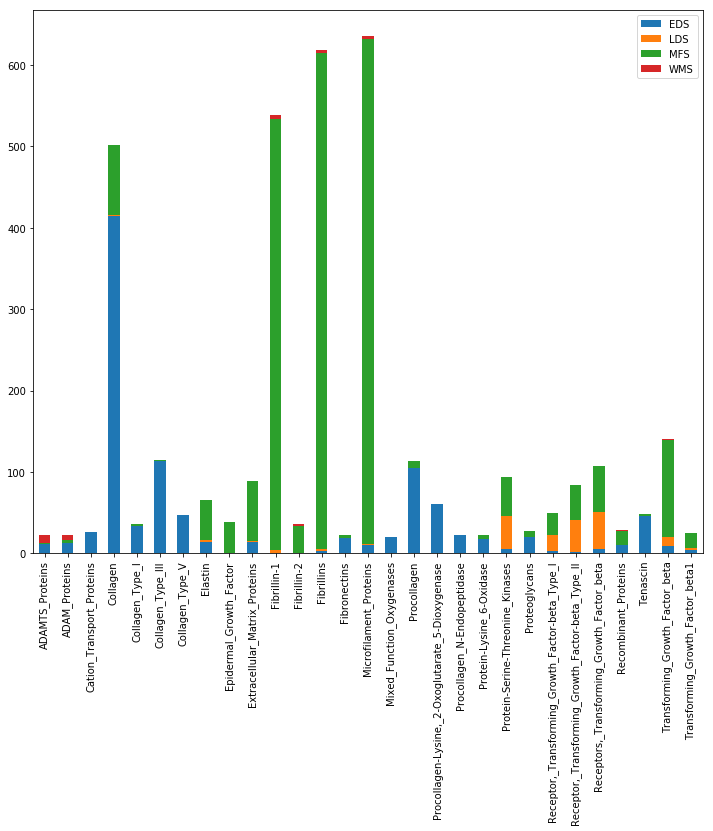

In [21]:
# Stacked Bar Chart for protein terms correlated with each Syndrome term, easy to draw conclusions about association, use to select model target and features
wms = tabulated_results.iloc[0]
eds = tabulated_results.iloc[1]
lds = tabulated_results.iloc[2]
mfs = tabulated_results.iloc[4]
new_df=pd.concat([eds, lds, mfs, wms], axis=1)
new_df.columns=["EDS", "LDS", "MFS", "WMS"]
new_df.plot(kind='bar', legend=True, figsize=(12, 10), stacked=True); 
plt.yscale('linear')

In [22]:
# Rename long protein names to fit and display better on graphs 
tab_results1 = tabulated_results.rename(columns={
'Procollagen-Lysine,_2-Oxoglutarate_5-Dioxygenase':'Pcol-Lys_2-Oxgl_5-DiOgenase',
'Protein-Serine-Threonine_Kinases': 'Protein-STKinases',
'Receptor,_Transforming_Growth_Factor-beta_Type_I': 'R_TGFBI',
'Receptor,_Transforming_Growth_Factor-beta_Type_II': 'R_TGFBII',
'Receptors,_Transforming_Growth_Factor_beta': 'R_TGFB', 'Transforming_Growth_Factor_beta': 'TGFB',
'Transforming_Growth_Factor_beta1': 'TGFB1',})

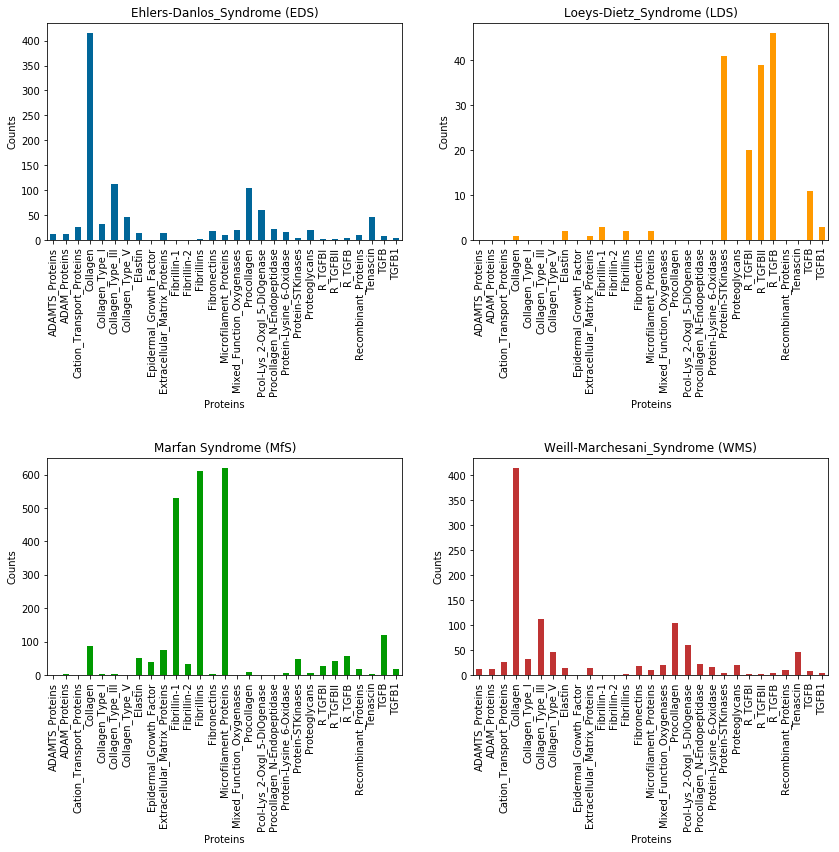

In [23]:
# Subplots of each of the 4 Syndromes plotted individually versus proteins: EDS, LDS, MfS, WMS
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust( hspace=1)

tab_results1.iloc[1].plot(kind='bar', legend=False, figsize=(14, 12), color=(0,.4,.6), ax=axes[0,0]);
axes[0,0].set_title('Ehlers-Danlos_Syndrome (EDS)');
axes[0,0].set_xlabel('Proteins')
axes[0,0].set_ylabel('Counts')

tab_results1.iloc[2].plot(kind='bar', legend=False, figsize=(14, 12), color=(1,0.6,0), ax=axes[0,1]);
axes[0,1].set_xlabel('Proteins')
axes[0,1].set_ylabel('Counts')
axes[0,1].set_title('Loeys-Dietz_Syndrome (LDS)');

tab_results1.iloc[4].plot(kind='bar', legend=False, figsize=(14, 12), color=(0,0.6,0), ax=axes[1,0]);
axes[1,0].set_xlabel('Proteins')
axes[1,0].set_ylabel('Counts')
axes[1,0].set_title('Marfan Syndrome (MfS)');

tab_results1.iloc[1].plot(kind='bar', legend=False, figsize=(14, 12), color=(.75,0.2,0.2), ax=axes[1,1]);
axes[1,1].set_xlabel('Proteins')
axes[1,1].set_ylabel('Counts')
axes[1,1].set_title('Weill-Marchesani_Syndrome (WMS)');

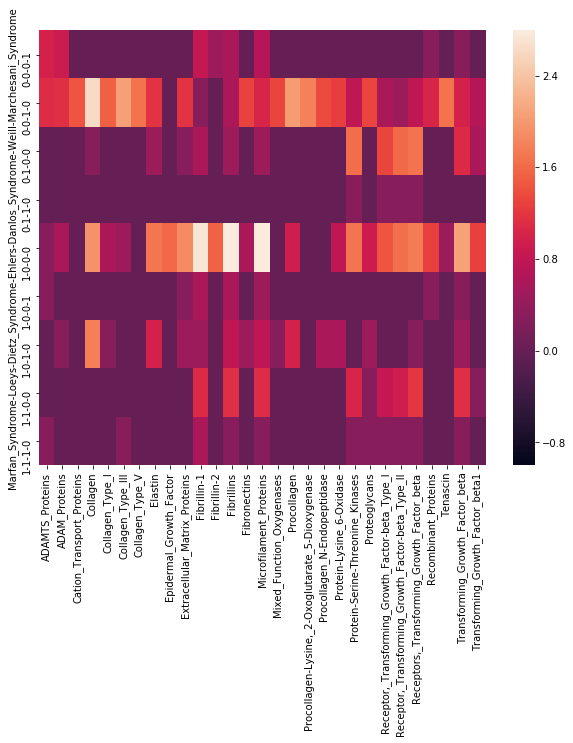

In [24]:
# Nine categories specified by binary code in order of MFS, LDS, EDS, WMS (see Tabulated Results in cell 12)
# Log Scale, (added 1 to 0 value in order to avoid log of 0, this will introduce a small amt of error, but not 
# significant since heatmaps are qualitative visualization of data) 
# This heatmap is more relevant to the data than the previous one 
plt.figure(figsize=(10,8))
sns.heatmap(np.log10(tabulated_results+1),vmin=-1);

### Best candidates for Models: target: MfS, Feature(s): Microfilament Proteins and (Fibrillins, Fibrillin-1, Collagen, TGF_beta) and for future analysis EDS: Collagen, LDS:TGFBR, PSTK, WMS: ADAMTS proteins

In [25]:
# Use for modeling: All Data
tf_2 = tf # Copy of Original Term Freq Dataframe
tf_2.shape

(8848, 33)

In [30]:
# Define X and y.
feature_cols = ['Fibrillins','Collagen', 'Transforming_Growth_Factor_beta', 'Microfilament_Proteins']
X = tf_2[feature_cols]
y = tf_2.Marfan_Syndrome
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1) # Split into train and test data
X_train.shape, y_train.shape

((6636, 4), (6636,))

In [31]:
# Use Naive Bayes to predict on All Data
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_class = nb.predict(X_test)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))
metrics.confusion_matrix(y_test, y_pred_class)

0.6907775768535263


array([[ 100,  651],
       [  33, 1428]], dtype=int64)

In [82]:
# Used All Data, to improve model decided to generate Filtered Data. Filtered Data: rows containing at least one protein term is used
fsl_model = final_simple_list # Start with original final_simple_list to generate a new dataframe with rows containing at least one protein term
def csv_analyzer(s):
    "split on space" 
    return [term for term in s.split()]
vect = CountVectorizer(analyzer=csv_analyzer, min_df=1) 

F = fsl_model
F1 = vect.fit_transform(F)

# Create new Dataframe with Protein term in each row, Filtered Data. This has 2145 rows while All Data has 8848 rows
syndrome_set = ['Marfan_Syndrome', 'Loeys-Dietz_Syndrome', 'Ehlers-Danlos_Syndrome', 'Weill-Marchesani_Syndrome']
filtered_model = []
for item in final_terms:
      if set(item).issubset(set(syndrome_set))==False:
#    if set(item) not in (set(syndrome_set)):
#       filtered_model.append(item)
        filtered_model.append(' '.join(item)) 
vect = CountVectorizer(analyzer=csv_analyzer, min_df=1) 
F = filtered_model
F1 = vect.fit_transform(F)

fmf = pd.DataFrame(vect.fit_transform(filtered_model).toarray(), columns=vect.get_feature_names())
fmf.shape # this Dataframe has more columns since column created for each protein term found and 4 Syndrome terms, total of 489 columns

(2145, 489)

In [83]:
# Define X and y for Filtered Data using fmf dataframe (or copy)
feature_cols = ['Fibrillins','Collagen', 'Transforming_Growth_Factor_beta', 'Microfilament_Proteins']
X = fmf[feature_cols]
y = fmf['Marfan_Syndrome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X[:10]
X_train.shape, X_test.shape

((1608, 4), (537, 4))

In [84]:
# Use Naive Bayes to predict presence of MfS term on Filtered Data
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_class = nb.predict(X_test)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))
metrics.confusion_matrix(y_test, y_pred_class) # Accuracy slightly less than All Data

0.6573556797020484


array([[ 95, 151],
       [ 33, 258]], dtype=int64)

0.6916817359855335


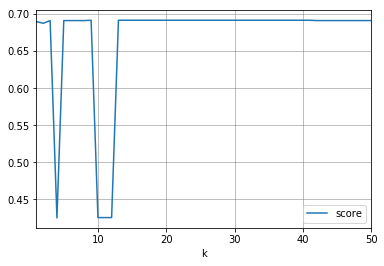

In [78]:
# Try different Models:
# k Nearest Neighbor on All Data, Five Features
feature_cols = ['Microfilament_Proteins', 'Fibrillins', 'Fibrillin-1', 'Collagen', 'Transforming_Growth_Factor_beta' ]
X = tf_2[feature_cols]
y = tf_2['Marfan_Syndrome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X[:10]
X_train.shape, X_test.shape

k_range = list(range(1, 51))
scores = []
max_score =0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    score = float(sum(pred == y_test)) / len(y_test)
    scores.append([k, score])
    if score>max_score: max_score=score
data = pd.DataFrame(scores,columns=['k','score']) # Plot Score versus number of neighbors
data.plot.line(x='k',y='score');
plt.grid(linestyle='-', linewidth='0.5', color='grey')
print(max_score)

In [79]:
# k Nearest Neighbor for Filtered Data, One Feature
feature_cols = ['Microfilament_Proteins']
X = fmf[feature_cols]
y = fmf['Marfan_Syndrome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X[:10]
X_train.shape, X_test.shape

((1608, 1), (537, 1))

In [80]:
k_range = list(range(1, 51))
scores = []
max_score =0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    score = float(sum(pred == y_test)) / len(y_test)
    scores.append([k, score])
    if score>max_score: max_score=score
print(max_score) # Filtered Data, One Feature

0.750465549348231


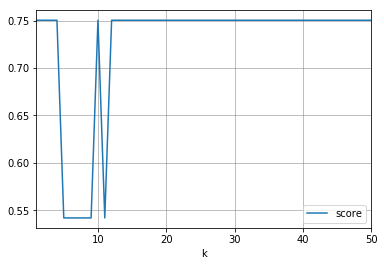

In [81]:
data = pd.DataFrame(scores,columns=['k','score']) # Plot Score versus number of neighbors
data.plot.line(x='k',y='score');
plt.grid(linestyle='-', linewidth='0.5', color='grey')

In [45]:
# k Nearest Neighbor for Filtered Data
feature_cols = ['Microfilament_Proteins', 'Fibrillins', 'Fibrillin-1', 'Collagen', 'Transforming_Growth_Factor_beta']
X = fmf[feature_cols]
y = fmf['Marfan_Syndrome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X[:10]
X_train.shape, X_test.shape

((1608, 5), (537, 5))

In [46]:
k_range = list(range(1, 51))
scores = []
max_score =0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    score = float(sum(pred == y_test)) / len(y_test)
    scores.append([k, score])
    if score>max_score: max_score=score
print(max_score) # Filtered Data, Five Features 

0.8156424581005587


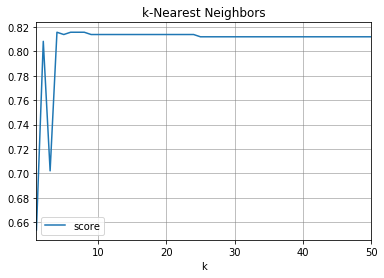

In [47]:
data = pd.DataFrame(scores,columns=['k','score']) # Plot score versus number of neighbors
data.plot.line(x='k',y='score');
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.title('k-Nearest Neighbors');

In [ ]:
### k-Nearest Neighbor Accuracy Scores: All Data, Five Feature: 0.69, Filtered Data, One Feature: 0.75, Filtered Data, Five Features: 0.82, the last is best model

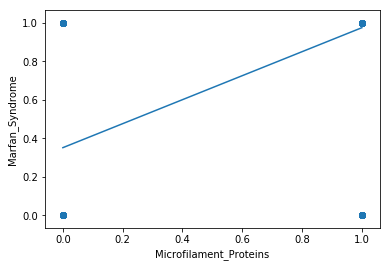

In [57]:
# Linear Regression on Filtered Data, One Feature 
lr = LinearRegression()
lr.fit(X, y) # Calculating the coefficients
lr.coef_, lr.intercept_ # underscore = private variables, should not be set = values

fmf_1 = fmf
fmf_1['Marfan_Syndrome_pred'] = lr.predict(X)

plt.scatter(fmf.Microfilament_Proteins, fmf.Marfan_Syndrome)
plt.xlabel('Microfilament_Proteins')
plt.ylabel('Marfan_Syndrome')

plt.plot(fmf_1.Microfilament_Proteins, fmf_1.Marfan_Syndrome_pred);

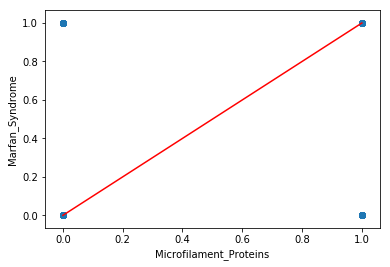

In [86]:
# Predicting MfS using Filtered Data, One Feature
fmf_1['Marfan_Syndrome_pred_class'] = np.where(fmf_1.Marfan_Syndrome_pred > 0.5, 1, 0)
fmf_1.sort_values('Microfilament_Proteins', inplace=True)

plt.scatter(fmf_1.Microfilament_Proteins, fmf_1.Marfan_Syndrome)
plt.xlabel('Microfilament_Proteins')
plt.ylabel('Marfan_Syndrome')
plt.plot(fmf_1.Microfilament_Proteins, fmf_1.Marfan_Syndrome_pred_class, color='red');

In [60]:
# Get a clear separation of the classes, Check accuracy score
score = float(sum(fmf_1.Marfan_Syndrome_pred_class == fmf_1.Marfan_Syndrome)) / len(fmf_1.Marfan_Syndrome)
score # Not as high as the k Nearest Neighbor for Filtered Data, Five Features

0.7482517482517482

In [61]:
# Confusion score shows a number of False Negatives, i.e. predicted MfS that are not actually MfS
metrics.confusion_matrix(fmf_1.Marfan_Syndrome,fmf_1.Marfan_Syndrome_pred_class)

array([[965,  16],
       [524, 640]], dtype=int64)

In [91]:
logreg = LogisticRegression()

feature_cols = ['Microfilament_Proteins']
X = fmf_1[feature_cols]
y = fmf_1.Marfan_Syndrome

logreg.fit(X,y)
fmf_1['Marfan_Syndrome_pred']= logreg.predict(X)

C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0, 0.5, 'Marfan_Syndrome')

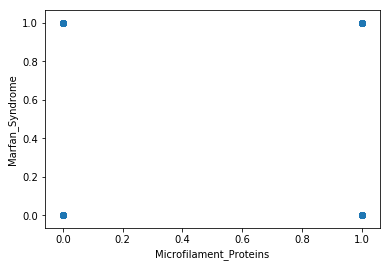

In [92]:
# Scatter plot for Filtered Data, One Feature shows 4 points
plt.scatter(fmf_1.Microfilament_Proteins, fmf_1.Marfan_Syndrome)
plt.xlabel('Microfilament_Proteins')
plt.ylabel('Marfan_Syndrome')

In [93]:
# Logistic Regression for Filtered Data, One Feature
logreg.predict_proba(X)[0:10]

array([[0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733],
       [0.64496267, 0.35503733]])

In [94]:
fmf_1['Marfan_Syndrome_pred_prob'] = logreg.predict_proba(X)[:,1]

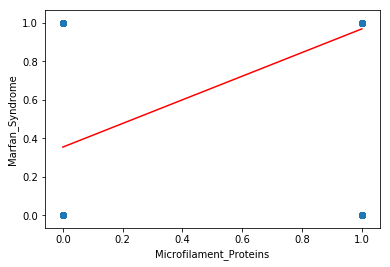

In [95]:
plt.scatter(fmf_1.Microfilament_Proteins, fmf_1.Marfan_Syndrome)
plt.plot(fmf_1.sort_values('Microfilament_Proteins').Microfilament_Proteins, fmf_1.sort_values('Microfilament_Proteins').Marfan_Syndrome_pred_prob, color='red')
plt.xlabel('Microfilament_Proteins')
plt.ylabel('Marfan_Syndrome');

In [67]:
print(logreg.predict_proba([[0], [1]])) # Predict probabilities

[[0.64496267 0.35503733]
 [0.03057141 0.96942859]]


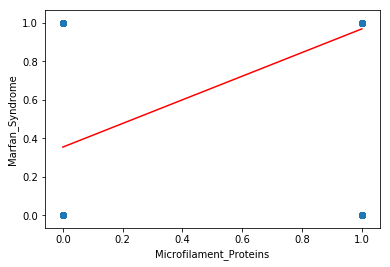

In [68]:
plt.scatter(fmf_1.Microfilament_Proteins, fmf_1.Marfan_Syndrome)
plt.plot(fmf_1.sort_values('Microfilament_Proteins').Microfilament_Proteins, \
         fmf_1.sort_values('Microfilament_Proteins').Marfan_Syndrome_pred_prob, color='red')
plt.xlabel('Microfilament_Proteins')
plt.ylabel('Marfan_Syndrome');

In [69]:
score = float(sum(fmf_1.Marfan_Syndrome_pred_class == fmf_1.Marfan_Syndrome)) / len(fmf_1.Marfan_Syndrome)
score # Same as Linear Regression

0.7482517482517482

In [70]:
# Linear Regression with Filtered Data and Five Features
feature_cols = ['Microfilament_Proteins', 'Fibrillins', 'Fibrillin-1', 'Collagen', 'Transforming_Growth_Factor_beta']

X = fmf_1[feature_cols]
y = fmf_1.Marfan_Syndrome

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

0.3745675812946674
[ 0.13382039  0.29167112  0.23235991 -0.13302073  0.19701672]


In [71]:
score = float(sum(fmf_1.Marfan_Syndrome_pred_class == fmf_1.Marfan_Syndrome)) / len(fmf_1.Marfan_Syndrome)
score # Same as Linear Regression of Filtered Data, One Feature

0.7482517482517482

# Results and Conclusion: 
### (1) Comparing Naive Bayes, Linear Regression, Logistic Regression and k Nearest Neighbors (kNN), kNN worked the best for modeling association with Marfan Syndrome. Using Filtered Data (size 2145 rows) with at least one protein term improved the model compared to All Data (size = 8848 rows). Using five features as features worked better than using one feature. (2) Proteins associated with EDS, LDS and WMS syndromes can be studied in the future. (3) This method of using indexed MeSH terms to study disease associations with symptoms, epidemiology and therapy may be used in future studies.